--- 1. Carregando e Pré-processando os Dados ---
--- Pré-processamento Concluído ---
Shape das features numéricas (X): (456, 43)

--- 2. Dividindo os Dados (Treino e Teste) ---
Tamanho do conjunto de Treino: 319 amostras
Tamanho do conjunto de Teste: 137 amostras

--- 3. Modelo 3: Treinando Random Forest (Floresta Aleatória) ---
Iniciando o treinamento do Random Forest...
--- Treinamento do Modelo 3 Concluído ---

--- 4. Avaliando o Modelo 3 (Random Forest) ---
Acurácia (Modelo 3): 0.6788

Relatório de Classificação (Modelo 3 - Random Forest):
              precision    recall  f1-score   support

negativo (0)       0.72      0.89      0.79        96
positivo (1)       0.42      0.20      0.27        41

    accuracy                           0.68       137
   macro avg       0.57      0.54      0.53       137
weighted avg       0.63      0.68      0.64       137


Matriz de Confusão (Modelo 3 - Random Forest):
            [Prev. Neg] [Prev. Pos]
[Real Neg]          85         11
[Real

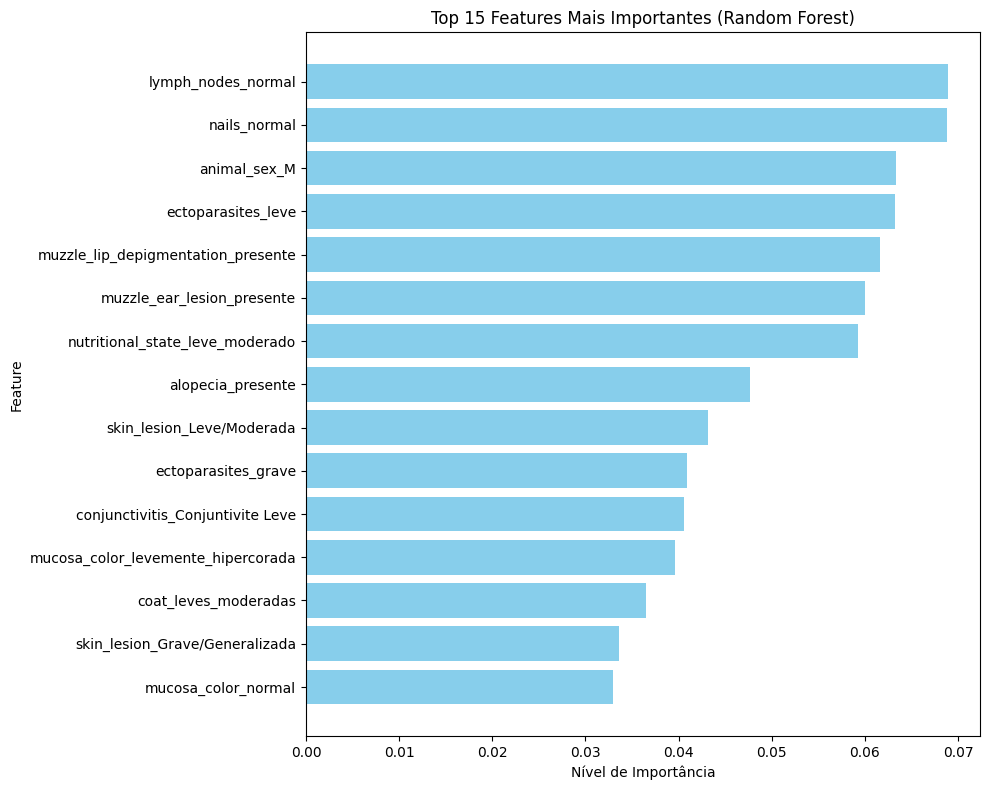

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier # <--- Importamos o RandomForest
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix
)
import matplotlib.pyplot as plt

# ==============================================================================
# --- 1. Carregando e Pré-processando os Dados ---
# ==============================================================================
print("--- 1. Carregando e Pré-processando os Dados ---")

# Carregar o dataset
file_path = '../data/raw/leish_dataset.csv'
df = pd.read_csv(file_path)

# Criar cópia para processamento
df_processed = df.copy()

# Lidar com valores ausentes (Missing)
for col in df_processed.select_dtypes(include=['object']).columns:
    df_processed[col] = df_processed[col].fillna('Unknown')

# Codificar a variável Alvo (Target)
target_map = {'positivo': 1, 'negativo': 0, 'Unknown': 0}
df_processed['diagnosis'] = df_processed['diagnosis'].map(target_map).astype(int)

# Separar features (X) e alvo (y)
X_categorical = df_processed.drop('diagnosis', axis=1)
y = df_processed['diagnosis']

# Aplicar One-Hot Encoding nas features categóricas
X_numeric = pd.get_dummies(X_categorical, drop_first=True, dtype=int)
# Salvar os nomes das colunas para a etapa de "Importância das Features"
feature_names = X_numeric.columns.tolist()

print("--- Pré-processamento Concluído ---")
print(f"Shape das features numéricas (X): {X_numeric.shape}")


# ==============================================================================
# --- 2. Dividindo os Dados (Treino e Teste) ---
# ==============================================================================
print("\n--- 2. Dividindo os Dados (Treino e Teste) ---")

X_train, X_test, y_train, y_test = train_test_split(
    X_numeric, 
    y, 
    test_size=0.3,
    random_state=42,
    stratify=y
)

print(f"Tamanho do conjunto de Treino: {X_train.shape[0]} amostras")
print(f"Tamanho do conjunto de Teste: {X_test.shape[0]} amostras")


# ==============================================================================
# --- 3. Modelo 3: Random Forest com class_weight='balanced' ---
# ==============================================================================
print("\n--- 3. Modelo 3: Treinando Random Forest (Floresta Aleatória) ---")

# Inicializar o classificador Random Forest
# n_estimators=100: Usaremos 100 árvores na "floresta"
# class_weight='balanced': A nossa correção para o desbalanceamento
# n_jobs=-1: Usar todos os núcleos do processador para acelerar
rf_classifier = RandomForestClassifier(
    n_estimators=100,        # Número de árvores
    class_weight='balanced', # Essencial para o nosso problema
    random_state=42,
    n_jobs=-1
)

# Treinar o modelo
print("Iniciando o treinamento do Random Forest...")
rf_classifier.fit(X_train, y_train)
print("--- Treinamento do Modelo 3 Concluído ---")


# ==============================================================================
# --- 4. Avaliando o Modelo 3 (Random Forest) ---
# ==============================================================================
print("\n--- 4. Avaliando o Modelo 3 (Random Forest) ---")

# Fazer previsões no conjunto de teste
y_pred_rf = rf_classifier.predict(X_test)

# Calcular a Acurácia
print(f"Acurácia (Modelo 3): {accuracy_score(y_test, y_pred_rf):.4f}")

# Exibir Relatório de Classificação
print("\nRelatório de Classificação (Modelo 3 - Random Forest):")
print(classification_report(y_test, y_pred_rf, target_names=['negativo (0)', 'positivo (1)']))

# Exibir Matriz de Confusão
print("\nMatriz de Confusão (Modelo 3 - Random Forest):")
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(f"            [Prev. Neg] [Prev. Pos]")
print(f"[Real Neg]  {cm_rf[0][0]:>10} {cm_rf[0][1]:>10}")
print(f"[Real Pos]  {cm_rf[1][0]:>10} {cm_rf[1][1]:>10}")


# ==============================================================================
# --- 5. BÔNUS: Importância das Features ---
# ==============================================================================
print("\n\n--- 5. BÔNUS: Importância das Features (Random Forest) ---")

# Extrair a importância de cada feature
importances = rf_classifier.feature_importances_

# Criar um DataFrame para facilitar a visualização
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False) # Ordenar da mais importante para a menos

print("Top 10 features mais importantes para o diagnóstico:")
print(feature_importance_df.head(10))

# --- Plotar as features mais importantes ---
plt.figure(figsize=(10, 8))
# Pegar as 15 primeiras para o gráfico
top_features = feature_importance_df.head(15)

# Criar gráfico de barras horizontal
plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
plt.title('Top 15 Features Mais Importantes (Random Forest)')
plt.xlabel('Nível de Importância')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Inverter o eixo Y para mostrar a mais importante no topo
plt.tight_layout()      # Ajustar layout para não cortar os nomes

# Salvar o gráfico
plt.savefig('random_forest_feature_importance.png')
print("\nGráfico de importância das features salvo em 'random_forest_feature_importance.png'")